In [1]:
import pandas as pd
import pulp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
s_df = pd.read_csv('j_kessan-2023.csv',index_col=0)

pd.set_option('display.max_columns',None)
s_df_T = s_df.applymap(lambda x: pd.to_numeric(str(x).replace(',',''), errors = 'coerce')).T
s_df_T.tail(5)

,スポンサー収入,入場料収入,Ｊリーグ配分金,アカデミー関連収入,女子チーム関連収入,物販収入,その他収入,トップチーム人件費,試合関連経費（ホームゲーム開催費）,トップチーム運営経費,アカデミー関連経費,女子チーム関連経費,物販関連費,その他売上原価,販売費および一般管理費,営業利益（-損失）,営業外収益,営業外費用,経常利益（-損失）,特別利益,特別損失,税引前当期利益（-損失）,法人税および住民税等,当期純利益（-損失）,NaN,関連する法人（アカデミーなどサッカー及びその他関連する事業を運営する法人）の営業収益,NaN,NaN,流動資産,固定資産等,資産の部 合計,流動負債,固定負債,負債の部 合計,資本金,資本剰余金等,利益剰余金,資本(純資産)の部 合計
Ｃ大阪,2741.0,900.0,280.0,0.0,182.0,225.0,540.0,2010.0,412.0,544.0,0.0,156.0,93.0,0.0,1242.0,411.0,60.0,68.0,403.0,0.0,0.0,403.0,2.0,401.0,NaN,1478.0,NaN,NaN,1890.0,342.0,2232.0,1451.0,326.0,1777.0,100.0,1585.0,-1230.0,455.0
神戸,2409.0,1320.0,536.0,256.0,0.0,831.0,1685.0,3800.0,514.0,385.0,434.0,0.0,386.0,902.0,1842.0,-1226.0,81.0,203.0,-1348.0,1400.0,3.0,49.0,18.0,31.0,NaN,0.0,NaN,NaN,1560.0,1709.0,3269.0,1705.0,144.0,1849.0,98.0,561.0,761.0,1420.0
広島,1864.0,631.0,315.0,103.0,311.0,411.0,563.0,2435.0,301.0,398.0,284.0,312.0,310.0,88.0,806.0,-736.0,28.0,41.0,-749.0,0.0,6.0,-755.0,2.0,-757.0,NaN,NaN,NaN,NaN,2663.0,1226.0,3889.0,1918.0,638.0,2556.0,2099.0,52.0,-818.0,1333.0
福岡,936.0,618.0,310.0,151.0,0.0,265.0,594.0,1611.0,145.0,225.0,193.0,0.0,185.0,162.0,445.0,-92.0,6.0,3.0,-89.0,0.0,0.0,-89.0,1.0,-90.0,NaN,NaN,NaN,NaN,459.0,320.0,779.0,1010.0,168.0,1178.0,383.0,455.0,-1237.0,-399.0
鳥栖,982.0,619.0,303.0,62.0,0.0,226.0,305.0,1016.0,127.0,206.0,208.0,0.0,135.0,329.0,329.0,147.0,79.0,68.0,158.0,0.0,0.0,158.0,31.0,127.0,NaN,NaN,NaN,NaN,1020.0,149.0,1169.0,729.0,598.0,1327.0,394.0,226.0,-778.0,-158.0


In [3]:
s_df_T.shape

(18, 38)

In [4]:
C = s_df_T.columns[7:8].tolist()+s_df_T.columns[9:10].tolist()
B = s_df_T.columns[1:3].tolist()
clubs = s_df_T.index.tolist()
columns = s_df_T.columns[1:15].tolist()
print(C)
print(B)
print(clubs)

['トップチーム人件費', 'トップチーム運営経費']
['入場料収入', 'Ｊリーグ配分金']
['札幌', '鹿島', '浦和', '柏', 'ＦＣ東京', '川崎Ｆ', '横浜ＦＭ', '横浜ＦＣ', '湘南', '新潟', '名古屋', '京都', 'Ｇ大阪', 'Ｃ大阪', '神戸', '広島', '福岡', '鳥栖']


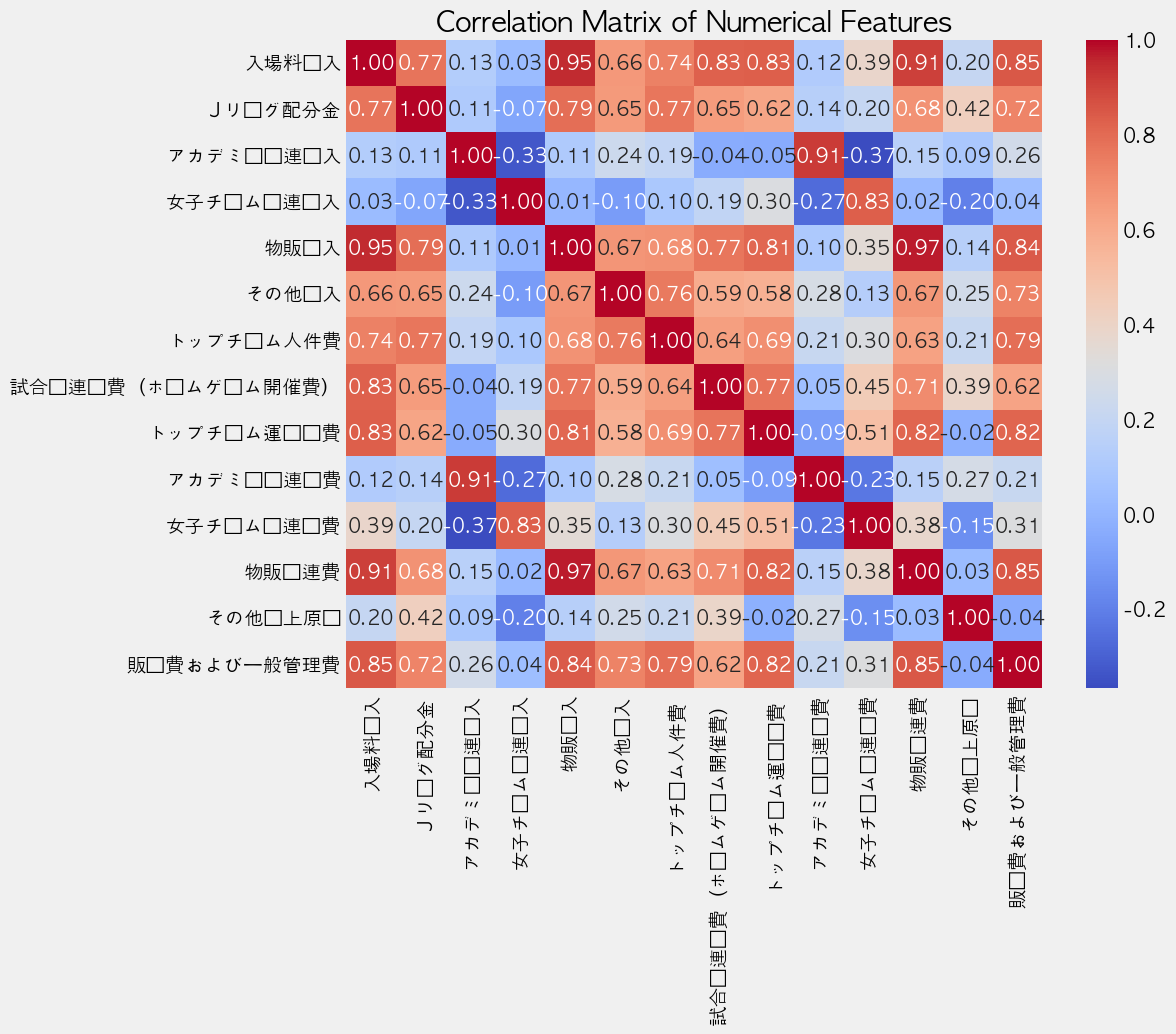

In [5]:
plt.rcParams['font.family'] = 'AppleGothic'  # macならこれでOK
plt.rcParams['axes.unicode_minus'] = False   # マイナスが文字化けしないように
correlation_matrix = s_df_T[columns].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [6]:
print(s_df_T.loc['鹿島','スポンサー収入'])

2418.0


In [7]:
result = []

for target in clubs:
    prob = pulp.LpProblem(f'jリーグ_{target}',pulp.LpMinimize)

    theta = pulp.LpVariable('theta',lowBound=0)

    lambda_vars = {club:pulp.LpVariable(f'lambda_{club}',lowBound=0) for club in clubs}
    for i in clubs:
        prob += lambda_vars[i]>=0 
    #入力制約
    for c in C:
        prob += s_df_T.loc[target,c]*theta >= pulp.lpSum(lambda_vars[club]*s_df_T.loc[club,c] for club in clubs)
    #出力制約
    for b in B:
        prob +=  pulp.lpSum(lambda_vars[club]*s_df_T.loc[club,b] for club in clubs) >= s_df_T.loc[target,b]
    #目的関数
    prob += theta
    prob.solve()

    lambda_values = {club: lambda_vars[club].value() for club in clubs}

    result.append({
        "クラブ名":target,
        "効率性":pulp.value(theta),
        "lambda": lambda_values
    })

result_df = pd.DataFrame(result)
print(result_df)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/xx/9mgb_75s5t99z6yk59t3c9d00000gn/T/189cabb391f64c9e8be6b8f2958f3f07-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/xx/9mgb_75s5t99z6yk59t3c9d00000gn/T/189cabb391f64c9e8be6b8f2958f3f07-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27 COLUMNS
At line 121 RHS
At line 144 BOUNDS
At line 145 ENDATA
Problem MODEL has 22 rows, 19 columns and 92 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (-18) rows, 19 (0) columns and 74 (-18) elements
Perturbing problem by 0.001% of 1.7823129 - largest nonzero change 4.7591702e-05 ( 0.0026702214%) - largest zero change 4.6924914e-05
0  Obj 0 Primal inf 1.0086914 (2)
4  Obj 0.56465566
Optimal - objective value 0.56461725
After Postsolve, objective 0.

In [8]:
lambda_df = result_df["lambda"].apply(pd.Series)
lambda_df.index = result_df["クラブ名"]
print(lambda_df.round(4))

       札幌   鹿島   浦和    柏  ＦＣ東京  川崎Ｆ  横浜ＦＭ  横浜ＦＣ      湘南      新潟  名古屋   京都  \
クラブ名                                                                        
札幌    0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.0000  0.0  0.0   
鹿島    0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.4179  0.0  0.0   
浦和    0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  2.5325  0.0  0.0   
柏     0.0  0.0  0.0  1.0   0.0  0.0   0.0   0.0  0.0000  0.0000  0.0  0.0   
ＦＣ東京  0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.4262  0.0  0.0   
川崎Ｆ   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.4852  0.0  0.0   
横浜ＦＭ  0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.7698  0.0  0.0   
横浜ＦＣ  0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  1.0261  0.0000  0.0  0.0   
湘南    0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  1.0000  0.0000  0.0  0.0   
新潟    0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.0000  0.0  0.0   
名古屋   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  0.0000  1.4675  0.0  0.0   

In [9]:
print(result_df.columns)

Index(['クラブ名', '効率性', 'lambda'], dtype='object')


In [10]:
result = []

selected_club = result_df["クラブ名"].tolist()
for target in selected_club:
    prob = pulp.LpProblem(f'jリーグ_{target}',pulp.LpMaximize)

    theta = pulp.LpVariable('theta',lowBound=1,upBound=1)
    d_slacks = {c: pulp.LpVariable(f'd_{c}_{target}', lowBound=0) for c in C}
    f_slacks = {b: pulp.LpVariable(f'f_{b}_{target}', lowBound=0) for b in B}
    lambda_vars = {club:pulp.LpVariable(f'lambda_{club}',lowBound=0) for club in clubs}
    
    prob += theta == 1

    #prob += pulp.lpSum(lambda_vars[i] for i in clubs)
    
    for i in clubs:
        prob += lambda_vars[i]>=0 
    for c in C:
        prob += d_slacks[c]>=0
    for b in B:
        prob += f_slacks[b]>=0
    #入力制約
    for c in C:
        prob += s_df_T.loc[target,c]*theta == pulp.lpSum(lambda_vars[club]*s_df_T.loc[club,c] for club in clubs)+d_slacks[c]
    #出力制約
    for b in B:
        prob +=  pulp.lpSum(lambda_vars[club]*s_df_T.loc[club,b] for club in clubs)-f_slacks[b] == s_df_T.loc[target,b]
    #目的関数
    prob += pulp.lpSum(d_slacks[c] for c in C )+pulp.lpSum(f_slacks[b] for b in B)
    prob.solve()
    
    result.append({
        "クラブ名": target,
        "スラック合計": pulp.value(prob.objective),
        **{f"d_{c}": pulp.value(d_slacks[c]) for c in C},
        **{f"f_{b}": pulp.value(f_slacks[b]) for b in B}
    })

result_df = pd.DataFrame(result)
print(result_df)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/xx/9mgb_75s5t99z6yk59t3c9d00000gn/T/4f06a1fcc9e14d4d8f6de724ed1fc170-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/xx/9mgb_75s5t99z6yk59t3c9d00000gn/T/4f06a1fcc9e14d4d8f6de724ed1fc170-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 32 COLUMNS
At line 138 RHS
At line 166 BOUNDS
At line 168 ENDATA
Problem MODEL has 27 rows, 23 columns and 101 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (-23) rows, 22 (-1) columns and 76 (-25) elements
Perturbing problem by 0.001% of 3860 - largest nonzero change 0.00036080352 ( 1.2515531e-05%) - largest zero change 0.00035493592
0  Obj -0 Primal inf 2.0161312 (4) Dual inf 7326.9993 (4)
5  Obj 1133.2411
Optimal - objective value 1133.2414
Afte